# Model Training
## Models to train:
- Classifiers:
  - Identify if observed orientation changes caused by head or phone, spit out class (movement) + cause (head vs phone)
  - Identify gesture, spit-out class (gesture performed, which will account for the cause also, e.g. head-turned-left vs phone-moved-right) - **Probs not this one**
- Regression:
  - Provide a actual value for the relative orientation + position of head and phone (may also need a classifier for the gesture)

## Variations:
- Single Model:</br>
  Take image, output gesture</br>
  Can only be called when image available and prior prediction complete, as such need to average other data (IMU)</br>
  Might not be possible to have *cond* tensor (e.g. change tensor used based on some condition), so may need a multiply based on input, e.g. provide 0 if face not found, and previous image given?
- Split Model:</br>
  Take image, get head pose, feed into second model with motion data to get gesture</br>
  Second model called as and when data (IMU or 1st model output) available (keeping prior values for pending data), first model called as and when image available</br>
  Can also be called with data averaged (e.g. only when image available)</br>
  Possibly use conditional tensor, will use different tensor object based on condition (e.g. face is visible in frame)
- Half Model:</br>
  Use model but only for some processing, e.g. just get landmarks (see: agarwal2020realtime & guobing2021headpose), or to get gesture
- Dual Model:</br>
  One model to get gesture from head (images), other to get gesture from phone (imu)</br>
  Simple algo to combine input to determine the gesture
  (e.g. one must be stationary, other moving)</br>
  Can possibly have in one model after joining after training? Maybe Markov Model


1. Classifier:
Cascade Classifier (first check if face and landmarks, then feed into trained model)</br>
RNN will be given sequence of Landmarks and IMU data, will classify to a given motion</br>
Might have issue with no 'stationary' class</br>
one-hot encoding for the class (classes will be gesture and direction)

2. Classifiers and HMM:
Use mocap data to determine delta between frames of phone and head movement (each with 6 DoF).</br>
Basically want to know which direction in each DoF is moving (or non if below threshold / can quantise data to speed-up training and runtime? no FP math).</br>
Model to output values of -1, 0, 1 for each DoF the head and phone (how get 3 possible states?)</br>
Feed in this encoded value to HMM (to also be trained), or can then transfer learn, and bolt on an RNN, tho then need to do sequences again?

Need to worry about whether tools used require region containing face to do their work, and if so how best to obtain region containing face that doesn't care for orientation.


# Loading Data
Preparing the data to use (e.g. read the csv into pandas dataframe)

Need to pre-load the images? Rotate them and resize them?</br>
Probably too large to fit all into memory (can exclude some for testing)

In [1]:
from os import listdir
from random import shuffle
import random
import csv
from pathlib import Path
from tkinter import NUMERIC
import pandas
import itertools as iter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 as cv
# import torch
import tensorflow as tf
import tensorflow.keras as keras
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2
# import keras.applications.MobileNetV2 as MobileNetV2
# from keras.applications.resnet50 import ResNet50 # quick, lighweight, and fairly accurate

MOTION_ENCODING = {
    '0|0|1': [0, 0, 1],
    '0|1|0': [0, 1, 0],
    '1|0|0': [1, 0, 0],   
}

CLASSES = [
    'NO_GESTURE',
    'POINTING_TRANSLATE_PHONE_TOP_CENTRE',
    'POINTING_TRANSLATE_PHONE_TOP_RIGHT',
    'POINTING_TRANSLATE_PHONE_MID_RIGHT',
    'POINTING_TRANSLATE_PHONE_BOTTOM_RIGHT',
    'POINTING_TRANSLATE_PHONE_BOTTOM_CENTRE',
    'POINTING_TRANSLATE_PHONE_BOTTOM_LEFT',
    'POINTING_TRANSLATE_PHONE_MID_LEFT',
    'POINTING_TRANSLATE_PHONE_TOP_LEFT',
    'POINTING_ROTATE_PHONE_TOP_CENTRE',
    'POINTING_ROTATE_PHONE_TOP_RIGHT',
    'POINTING_ROTATE_PHONE_MID_RIGHT',
    'POINTING_ROTATE_PHONE_BOTTOM_RIGHT',
    'POINTING_ROTATE_PHONE_BOTTOM_CENTRE',
    'POINTING_ROTATE_PHONE_BOTTOM_LEFT',
    'POINTING_ROTATE_PHONE_MID_LEFT',
    'POINTING_ROTATE_PHONE_TOP_LEFT',
    'POINTING_ROTATE_HEAD_TOP_CENTRE',
    'POINTING_ROTATE_HEAD_TOP_RIGHT',
    'POINTING_ROTATE_HEAD_MID_RIGHT',
    'POINTING_ROTATE_HEAD_BOTTOM_RIGHT',
    'POINTING_ROTATE_HEAD_BOTTOM_CENTRE',
    'POINTING_ROTATE_HEAD_BOTTOM_LEFT',
    'POINTING_ROTATE_HEAD_MID_LEFT',
    'POINTING_ROTATE_HEAD_TOP_LEFT',
    'TRANSLATE_PHONE_TOP_CENTRE',
    'TRANSLATE_PHONE_MID_RIGHT',
    'TRANSLATE_PHONE_BOTTOM_CENTRE',
    'TRANSLATE_PHONE_MID_LEFT',
    'CIRCULAR_PHONE_CLOCKWISE',
    'CIRCULAR_PHONE_ANTI_CLOCKWISE',
    'CIRCULAR_HEAD_CLOCKWISE',
    'CIRCULAR_HEAD_ANTI_CLOCKWISE',
    'ZOOM_PHONE_ZOOM_IN',
    'ZOOM_PHONE_ZOOM_OUT',
    'ZOOM_HEAD_ZOOM_IN',
    'ZOOM_HEAD_ZOOM_OUT',
    'ROTATE_HEAD_TOP_CENTRE',
    'ROTATE_HEAD_MID_RIGHT',
    'ROTATE_HEAD_BOTTOM_CENTRE',
    'ROTATE_HEAD_MID_LEFT',
    'ROTATE_PHONE_ROLL_CLOCKWISE',
    'ROTATE_PHONE_ROLL_ANTI_CLOCKWISE',
    'ROTATE_HEAD_ROLL_CLOCKWISE',
    'ROTATE_HEAD_ROLL_ANTI_CLOCKWISE'
]

ENCODED_GESTURES = keras.utils.to_categorical(range(len(CLASSES)))
GESTURE_TO_ENCODING = {key: value for key, value in zip(CLASSES, ENCODED_GESTURES)}
print(GESTURE_TO_ENCODING)

YUNET_FIELDS = [
    'BB_X','BB_WIDTH','BB_Y','BB_HEIGHT','BB_EYE_R_X','BB_EYE_R_Y','BB_EYE_L_X','BB_EYE_L_Y',
    'BB_NOSE_X','BB_NOSE_Y','BB_MOUTH_R_X','BB_MOUTH_R_Y','BB_MOUTH_L_X','BB_MOUTH_L_Y'
]
MOTION_YUNET_FIELDS = [*[f"{field}_1" for field in YUNET_FIELDS], *[f"{field}_2" for field in YUNET_FIELDS]]

POSE_INPUT_CSV_FIELD_NAMES = [
    'DELTA', 'IMG_PATH', 'FACE_DETECTED', *YUNET_FIELDS, 
    'LINEAR_X', 'LINEAR_Y', 'LINEAR_Z', 'ROTATION_X', 'ROTATION_Y', 'ROTATION_Z',
    'PHONE_X', 'PHONE_Y', 'PHONE_Z', 'PHONE_ROLL', 'PHONE_PITCH', 'PHONE_YAW', 
    'HEAD_X', 'HEAD_Y', 'HEAD_Z', 'HEAD_ROLL', 'HEAD_PITCH', 'HEAD_YAW'
]

MOTION_INPUT_CSV_FIELD_NAMES = [
    'DELTA', 'IMG_PATH_1', 'FACE_DETECTED_1', *[f"{field}_1" for field in YUNET_FIELDS], 
    'IMG_PATH_2', 'FACE_DETECTED_2', *[f"{field}_2" for field in YUNET_FIELDS], 
    'LINEAR_X', 'LINEAR_Y', 'LINEAR_Z', 'ROTATION_X', 'ROTATION_Y', 'ROTATION_Z',
    'PHONE_X', 'PHONE_Y', 'PHONE_Z', 'PHONE_ROLL', 'PHONE_PITCH', 'PHONE_YAW', 
    'HEAD_X', 'HEAD_Y', 'HEAD_Z', 'HEAD_ROLL', 'HEAD_PITCH', 'HEAD_YAW'
]

POSE_NUMERIC_FIELDS = [
    'DELTA', *YUNET_FIELDS, 'LINEAR_X', 'LINEAR_Y', 'LINEAR_Z', 'ROTATION_X', 'ROTATION_Y', 'ROTATION_Z',
    'PHONE_X', 'PHONE_Y', 'PHONE_Z', 'PHONE_ROLL', 'PHONE_PITCH', 'PHONE_YAW', 
    'HEAD_X', 'HEAD_Y', 'HEAD_Z', 'HEAD_ROLL', 'HEAD_PITCH', 'HEAD_YAW'
]

MOTION_NUMERIC_FIELDS = [
    'DELTA', *MOTION_YUNET_FIELDS, 'LINEAR_X', 'LINEAR_Y', 'LINEAR_Z', 'ROTATION_X', 'ROTATION_Y', 'ROTATION_Z'
]

ACCELERATION_FIELDS = [
    'LINEAR_X', 'LINEAR_Y', 'LINEAR_Z', 'ROTATION_X', 'ROTATION_Y', 'ROTATION_Z'
]

MOTION_ENCODED_FIELDS = [
    'PHONE_X', 'PHONE_Y', 'PHONE_Z', 'PHONE_ROLL', 'PHONE_PITCH', 'PHONE_YAW',
    'HEAD_X', 'HEAD_Y', 'HEAD_Z', 'HEAD_ROLL', 'HEAD_PITCH', 'HEAD_YAW'
]

{'NO_GESTURE': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'POINTING_TRANSLATE_PHONE_TOP_CENTRE': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'POINTING_TRANSLATE_PHONE_TOP_RIGHT': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'POINTING_TRANSLATE_PHONE_MID_RIGHT': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [8]:
import time
IMAGE_PATH = Path('/mnt/e/Uni/CM50175/Study/data/synchronisation')
image_width = 180
image_height = 320
image_channels = 3
img_input_shape = (image_height, image_width*2, image_channels)

# Derived from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

def import_img(path):
    img = cv.imread(str(path))
    img = cv.resize(img, (320, 180))
    img = np.rot90(img)
    img = np.ascontiguousarray(img)
    return img

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=10, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.data = data_frame
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        img_input = np.empty((self.batch_size, *img_input_shape))
        acc_input = np.empty((self.batch_size, 6))
        y = {field: np.empty((self.batch_size, 3)) for field in MOTION_ENCODED_FIELDS}# np.empty((self.batch_size, 12, 3))
        # y = np.empty((self.batch_size, 12, 3))
        # Generate data
        for i, idx in enumerate(indices):
            # Store sample
            img_path_1 = IMAGE_PATH / f"{self.data.iloc[idx]['IMG_PATH_1']}.png"
            img_path_2 = IMAGE_PATH / f"{self.data.iloc[idx]['IMG_PATH_2']}.png"

            img_1 = import_img(str(img_path_1))
            img_2 = import_img(str(img_path_2))
            # img_concat = np.concatenate((img_1, img_2), axis=1).astype(np.float64) / 255
            img_input[i] = np.concatenate((img_1, img_2), axis=1).astype(np.float64) / 255

            acc_input[i] = np.array(self.data.iloc[idx][ACCELERATION_FIELDS].values)
            # print(acc_input)
            # acc_input = np.concatenate(acc_input)

            # Store class
            for field, batch in y.items():
                batch[i] = self.data.iloc[idx][field]
            # y[i] = np.concatenate(self.data.iloc[idx][MOTION_ENCODED_FIELDS].values).reshape((12,3))

        return (img_input, acc_input), (y['PHONE_X'], y['PHONE_Y'], y['PHONE_Z'], y['PHONE_ROLL'], y['PHONE_PITCH'], y['PHONE_YAW'], y['HEAD_X'], y['HEAD_Y'], y['HEAD_Z'], y['HEAD_ROLL'], y['HEAD_PITCH'], y['HEAD_YAW'])


In [6]:
import time

DATA_PATH = Path('/mnt/e/Uni/CM50175/Study/data/training_data/NN/MOTION')

def get_file_paths():
    return [(file_path.name) for file_path in DATA_PATH.iterdir()]

def time_formatted(delta_ms):
    min = int((delta_ms/(1000*60))%60)
    sec = int(((delta_ms - min)/1000)%60)
    ms = int(delta_ms - (min*60*1000) - (sec*1000))
    return min, sec, ms

def convert_encoding_str_to_array(str):
    return np.array([float(val) for val in str.split('|')])
    
def get_data_frame(input_files_root, input_files):
    first = round(time.time() * 1000)
    imported_data = []
    count = 0
    last_batch = first
    for file in input_files:
        count += 1
        participant = file[-7]
        df = pandas.read_csv(input_files_root / file)
        
        # process columns
        df = df.rename(columns={'LINEAR_X.1': 'LINEAR_Z'}) # wrong output resulting in duped column name...
        df[MOTION_NUMERIC_FIELDS] = df[MOTION_NUMERIC_FIELDS].apply(pandas.to_numeric, errors='coerce')
        df[MOTION_ENCODED_FIELDS] = df[MOTION_ENCODED_FIELDS].apply(lambda series: series.map(convert_encoding_str_to_array))
        df[['IMG_PATH_1', 'IMG_PATH_2']] = df[['IMG_PATH_1', 'IMG_PATH_2']].apply(lambda series: series.map(lambda img_path: f"{participant}/{img_path}"))
        df.astype({'FACE_DETECTED_1': bool, 'FACE_DETECTED_2': bool})
        # print(df.keys())
        df = df.drop(MOTION_YUNET_FIELDS, axis=1)

        imported_data.append(df)

        # log summary
        if count % 2000 == 0:
            now = round(time.time() * 1000)
            first_diff = time_formatted(now-first)
            batch_diff = time_formatted(now-last_batch)
            print(f"{count} Files read - {batch_diff[0]}:{batch_diff[1]}.{batch_diff[2]} for current batch, {first_diff[0]}:{first_diff[1]}.{first_diff[2]} since start")
            last_batch = now

    print(f"All {count} Files Loaded")
    concat_now = round(time.time() * 1000)
    imported_data = pandas.concat(imported_data, axis=0, ignore_index=True, sort=False)
    now = round(time.time() * 1000)
    first_diff = time_formatted(now-first)
    concat_diff = time_formatted(now-concat_now)
    print(f"Concat Complete - {concat_diff[0]}:{concat_diff[1]}.{concat_diff[2]} for concat, {first_diff[0]}:{first_diff[1]}.{first_diff[2]} since start")
    return imported_data

file_paths = list(filter(lambda file_name: file_name.startswith('10_'), get_file_paths()))
print(f'Number of files to process: {len(file_paths)}')

# train_val_paths, test_paths = train_test_split(file_paths, test_size=0.2, random_state=28)
# train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2, random_state=16)

# print(f"Testing paths: {len(test_paths)}, Training: {len(train_paths)}, Validation: {len(val_paths)}")

# train_data_frame = get_data_frame(DATA_PATH, train_paths)
# val_data_frame = get_data_frame(DATA_PATH, val_paths)
# test_data_frame = get_data_frame(DATA_PATH, test_paths)

Number of files to process: 4971


# Build Model

In [ ]:
# tf.debugging.set_log_device_placement(False)

# Transfer Learning Motion Encoder
regularisation = 0.01
dropout = 0.2

# concat_img = np.concatenate((old_img, new_img), axis=0)
img_input = keras.Input(shape=img_input_shape)
mnetv2 = MobileNetV2(input_tensor=img_input, input_shape=img_input_shape, weights='imagenet', include_top=False)
mnetv2.trainable = False
img_cnn = keras.layers.Conv2D(512, (4,4), padding='same', activation='relu')(mnetv2.output)
img_cnn = layers.MaxPooling2D((2,2))(img_cnn)
img_cnn = layers.BatchNormalization(axis = 3)(img_cnn)
img_cnn = keras.layers.Conv2D(128, (2,2), padding='same', activation='relu')(img_cnn)
img_cnn = keras.layers.Flatten()(img_cnn)
img_fcn = keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(regularisation))(img_cnn)
img_fcn = keras.layers.Dropout(dropout)(img_fcn)
img_fcn_out = keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(regularisation))(img_fcn)
# combined_img_model = keras.Model(inputs=[old_img_model.input, new_img_model.input], outputs=img_fcn_out, name='Combined IMG Model')

# The Linear and Angular acceleration from the phone
acc_in = keras.Input(shape=(6,))
# acc_fcn = keras.layers.Dense(36, activation='relu')(acc_in)
# acc_model = keras.Model(inputs=input_acc, outputs=acc_fcn, name='ACC Model')

final_model = keras.layers.Concatenate()([img_fcn_out, acc_in]) # acc_fcn])
final_model = keras.layers.Dropout(dropout)(final_model)
final_model = keras.layers.Dense(36, activation='relu')(final_model)
final_model = keras.layers.Dropout(dropout)(final_model)
# final_model = keras.layers.Dense(12*3)(final_model)
# final_model = keras.layers.Reshape((12,3))(final_model)
# output = keras.layers.Softmax()(final_model)

phone_x = keras.layers.Dense(3, name="Phone_x", activation='softmax')(final_model)
phone_y = keras.layers.Dense(3, name="Phone_y", activation='softmax')(final_model)
phone_z = keras.layers.Dense(3, name="Phone_z", activation='softmax')(final_model)
phone_roll = keras.layers.Dense(3, name="Phone_roll", activation='softmax')(final_model)
phone_pitch = keras.layers.Dense(3, name="Phone_pitch", activation='softmax')(final_model)
phone_yaw = keras.layers.Dense(3, name="Phone_yaw", activation='softmax')(final_model)
head_x = keras.layers.Dense(3, name="Head_x", activation='softmax')(final_model)
head_y = keras.layers.Dense(3, name="Head_y", activation='softmax')(final_model)
head_z = keras.layers.Dense(3, name="Head_z", activation='softmax')(final_model)
head_roll = keras.layers.Dense(3, name="Head_roll", activation='softmax')(final_model)
head_pitch = keras.layers.Dense(3, name="Head_pitch", activation='softmax')(final_model)
head_yaw = keras.layers.Dense(3, name="Head_yaw", activation='softmax')(final_model)

tl_model = keras.Model(inputs=[img_input, acc_in], outputs=[phone_x,phone_y,phone_z,phone_roll,phone_pitch,phone_yaw,head_x,head_y,head_z,head_roll,head_pitch,head_yaw], name="MotionEncoder") # outputs=[phone_x,phone_y,phone_z,phone_roll,phone_pitch,phone_yaw,head_x,head_y,head_z,head_roll,head_pitch,head_yaw]
tl_model.summary()
plot_model(tl_model, show_shapes=True)

# Train Model

In [16]:
from keras.metrics import categorical_accuracy
# Code sampled from coursework from another unit: https://colab.research.google.com/drive/1rFKfHzzp0lgjYBCbP1GG0Ttn77acamw2?authuser=2#scrollTo=1pl5bSA5VT3Y
train_ds = DataGenerator(train_data_frame, batch_size=64)
val_ds = DataGenerator(val_data_frame, batch_size=64)
test_ds = DataGenerator(test_data_frame, batch_size=64)

model_path = Path('/mnt/e/Uni/CM50175/Study/data/training_data/NN/')
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, # learning rate determined by hyper-param-tuning
    decay_steps=(train_ds.__len__() // train_ds.batch_size), # decay every 2 epochs
    decay_rate=0.9)
tf.debugging.set_log_device_placement(False)
# compile model
tl_model_compiled = tl_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics='accuracy')

tl_model_epoch_count = 20
tl_model_train_steps_per_epoch = train_ds.__len__() // (train_ds.batch_size / 2)
tl_model_val_steps_per_epoch = val_ds.__len__() // (val_ds.batch_size / 2)

print("training steps per epoch: {}\nvalidation steps per epoch: {}".format(tl_model_train_steps_per_epoch, tl_model_val_steps_per_epoch))
checkpoint_path = model_path / 'checkpoints'
checkpoint_path.mkdir(exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
    mode='min', restore_best_weights=True
)

print("Fitting Transfer Learning Model (using MobileNetV2)")
tl_model_history = tl_model.fit(
    x = train_ds,
    validation_data=val_ds,
    epochs=tl_model_epoch_count,
    steps_per_epoch=tl_model_train_steps_per_epoch,
    validation_steps=tl_model_val_steps_per_epoch,
    callbacks=[early_stop_cb, model_checkpoint_callback]
)

tl_model.save(str(model_path / "TL_MODEL.h5"))

119/119 [==============================] - 1226s 10s/step - loss: 9.5664 - Phone_x_loss: 1.0321 - Phone_y_loss: 1.0519 - Phone_z_loss: 1.0436 - Phone_roll_loss: 0.7971 - Phone_pitch_loss: 0.5587 - Phone_yaw_loss: 0.5266 - Head_x_loss: 1.0358 - Head_y_loss: 0.9689 - Head_z_loss: 0.7117 - Head_roll_loss: 0.5408 - Head_pitch_loss: 0.6317 - Head_yaw_loss: 0.6358 - Phone_x_accuracy: 0.4590 - Phone_y_accuracy: 0.4347 - Phone_z_accuracy: 0.4548 - Phone_roll_accuracy: 0.6840 - Phone_pitch_accuracy: 0.8189 - Phone_yaw_accuracy: 0.8413 - Head_x_accuracy: 0.4602 - Head_y_accuracy: 0.5511 - Head_z_accuracy: 0.7346 - Head_roll_accuracy: 0.8313 - Head_pitch_accuracy: 0.7788 - Head_yaw_accuracy: 0.7853 - val_loss: 9.4670 - val_Phone_x_loss: 1.0285 - val_Phone_y_loss: 1.0316 - val_Phone_z_loss: 1.0364 - val_Phone_roll_loss: 0.7849 - val_Phone_pitch_loss: 0.4909 - val_Phone_yaw_loss: 0.5005 - val_Head_x_loss: 1.0308 - val_Head_y_loss: 0.9673 - val_Head_z_loss: 0.7379 - val_Head_roll_loss: 0.5724 - val_

# Model Evaluation

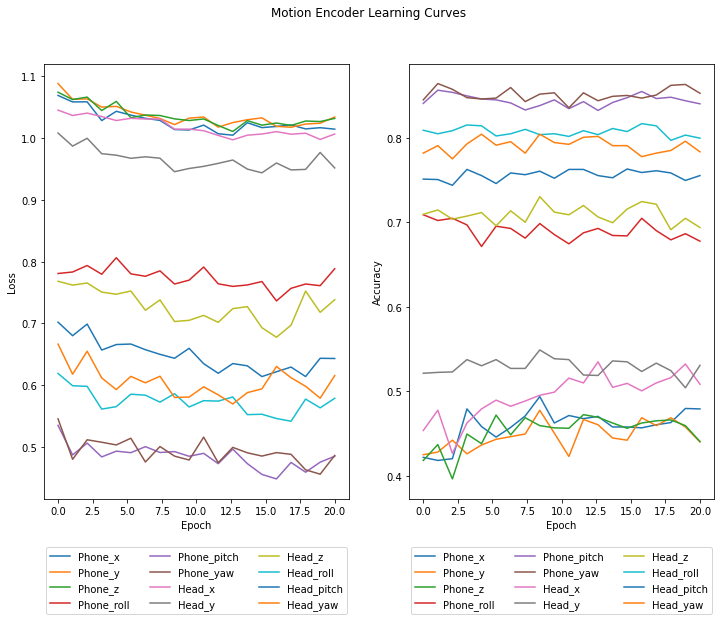

In [18]:
# Code sampled from coursework from another unit: https://colab.research.google.com/drive/1rFKfHzzp0lgjYBCbP1GG0Ttn77acamw2?authuser=2#scrollTo=1pl5bSA5VT3Y
epochs = np.linspace(0, 20, 20)

loss_labels = ['Phone_x_loss', 'Phone_y_loss', 'Phone_z_loss', 'Phone_roll_loss', 'Phone_pitch_loss', 'Phone_yaw_loss', 'Head_x_loss', 'Head_y_loss', 'Head_z_loss', 'Head_roll_loss', 'Head_pitch_loss', 'Head_yaw_loss'] 
accuracy_labels = ['Phone_x_accuracy', 'Phone_y_accuracy', 'Phone_z_accuracy', 'Phone_roll_accuracy', 'Phone_pitch_accuracy', 'Phone_yaw_accuracy', 'Head_x_accuracy', 'Head_y_accuracy', 'Head_z_accuracy', 'Head_roll_accuracy', 'Head_pitch_accuracy', 'Head_yaw_accuracy']

fig, (encoding_loss, encoding_accuracy) = plt.subplots(1, 2, sharex=True)
fig.suptitle("Motion Encoder Learning Curves")
fig.set_size_inches(12,8)

encoding_loss.set_xlabel("Epoch")
encoding_loss.set_ylabel("Loss")
for loss in loss_labels:
    # encoding_loss.plot(epochs, tl_model_history.history[loss], label=loss[:-5])
    encoding_loss.plot(epochs, tl_model_history.history[f'val_{loss}'], label=f'{loss[:-5]}')
encoding_loss.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.10))

encoding_accuracy.set_xlabel("Epoch")
encoding_accuracy.set_ylabel("Accuracy")
for accuracy in accuracy_labels:
    # encoding_accuracy.plot(epochs, tl_model_history.history[accuracy], label=accuracy[:-9])
    encoding_accuracy.plot(epochs, tl_model_history.history[f'val_{accuracy}'], label=f'{accuracy[:-9]}')
encoding_accuracy.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.10))

plt.show()

In [14]:
import time
model_path = Path('/mnt/e/Uni/CM50175/Study/data/training_data/NN/')
tl_model = keras.models.load_model(str(model_path / "TL_MODEL.h5"))

# DATA_PATH = Path('/mnt/e/Uni/CM50175/Study/data/training_data/NN/MOTION')

# def get_file_paths():
#     return [(file_path.name) for file_path in DATA_PATH.iterdir()]

_, test_paths = train_test_split(file_paths, test_size=0.2, random_state=28)

test_data_frame = get_data_frame(DATA_PATH, test_paths)[0:500]

test_ds = DataGenerator(test_data_frame, batch_size=1)
# tl_model_evaluation = tl_model.predict(test_ds)

confusion = {key: (np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0])) for key in MOTION_ENCODED_FIELDS}
for i in range(10):
    input, actual = test_ds.__getitem__(i)
    predictions = tl_model.predict((input))
    for idx, key in enumerate(MOTION_ENCODED_FIELDS):
        pred = predictions[0][idx]
        if actual[0][idx][0] == 1:
            confusion[0][key][0] = np.sum([confusion[key][0], pred])
        elif actual[idx][1] == 1:
            confusion[key][1] = np.sum([confusion[key][1], pred])
        else:
            confusion[key][2] = np.sum([confusion[key][2], pred])

print(confusion)

All 995 Files Loaded
Concat Complete - 0:0.261 for concat, 0:25.543 since start
1/1 [==============================] - 1s 725ms/step


IndexError: index 1 is out of bounds for axis 0 with size 1

In [12]:
print(dict(zip(tl_model.metrics_names, tl_model_evaluation)))

{'loss': 8.683426856994629, 'Phone_x_loss': 0.9207941889762878, 'Phone_y_loss': 0.9290529489517212, 'Phone_z_loss': 0.9312819242477417, 'Phone_roll_loss': 0.5909066200256348, 'Phone_pitch_loss': 0.39036378264427185, 'Phone_yaw_loss': 0.2691478431224823, 'Head_x_loss': 1.0518567562103271, 'Head_y_loss': 0.9172331094741821, 'Head_z_loss': 0.7389829754829407, 'Head_roll_loss': 0.5507842898368835, 'Head_pitch_loss': 0.6749629974365234, 'Head_yaw_loss': 0.6886705756187439, 'Phone_x_accuracy': 0.5625, 'Phone_y_accuracy': 0.6272321343421936, 'Phone_z_accuracy': 0.4129464328289032, 'Phone_roll_accuracy': 0.7366071343421936, 'Phone_pitch_accuracy': 0.8727678656578064, 'Phone_yaw_accuracy': 0.9441964030265808, 'Head_x_accuracy': 0.546875, 'Head_y_accuracy': 0.6227678656578064, 'Head_z_accuracy': 0.6629464030265808, 'Head_roll_accuracy': 0.8080357313156128, 'Head_pitch_accuracy': 0.6964285969734192, 'Head_yaw_accuracy': 0.7165178656578064}


# Gesture Classification

In [73]:
from random import randrange
# new data generator (need gesture from file name as output (encoded))
# Also need to window the data, padding with [0,0,0] if no prior input
# need to join windows different gestures?
# grab random 4-8 gestures and string together as single output?

# input_shape = (20, 12, 3) # might need to drop the 3, and convert one-hot to value, e.g. 0, 1, 2...

class MotionGenerator(keras.utils.Sequence):
    def __init__(self, data_frames, input_length=20, batch_size=32, shuffle=True):
        'Initialization'
        self.data = data_frames
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.input_length = input_length
        self.on_epoch_end()

    def get_indices(self):
        self.window_indices = []
        for idx, data_idx in enumerate(self.indexes):
            for i in range(self.data[data_idx].shape[0]):
                window = []
                window_start = (data_idx, i)
                window_end = i + self.input_length
                if self.data[data_idx].shape[0] < window_end:
                    window.append((*window_start, self.data[data_idx].shape[0]))
                    window_end = (window_end - self.data[data_idx].shape[0])
                    if idx+1 == len(self.indexes):
                        break # no more data
                    nextIdx = self.indexes[idx+1]
                    window_start=(nextIdx, 0)

                    if self.data[nextIdx].shape[0] < window_end:
                        # print(f"next sequence too small: {self.data[nextIdx].shape[0]}")
                        window_end = (window_end - self.data[nextIdx].shape[0])
                        window.append((*window_start, self.data[nextIdx].shape[0]))
                        if idx+2 == len(self.indexes):
                            break # no more data
                        nextIdx = self.indexes[idx+2]
                        window_start = (nextIdx, 0)

                window.append((*window_start, window_end))
                    # print(window)
                self.window_indices.append(window)
        print(len(self.window_indices))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.window_indices) // self.batch_size

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        self.get_indices()

    def get_slice(self, index):
        # print(index)
        windows = []
        for source, start, end in index:
            windows.append(self.data[source].iloc[start:end])
        
        if len(windows) == 1:
            window = windows[0]
            gesture_class = window.iloc[0]['CLASS']
        else:
            window = pandas.concat(windows, ignore_index=True)
            gesture_class = window['CLASS'].explode().value_counts()[0]
            # gesture_class = np.mean(np.stack(window['CLASS'].to_numpy(), axis=0), axis=0)
            
        if len(window.index) < 20:
            print(f"window length: {len(window.index)}, indices: {[(idx, len(windows[i].shape[0]), self.data[idx[0]].shape[0]) for i, idx in enumerate(index)]}")

        motions = np.stack(window.drop('CLASS', axis=1).to_numpy(), axis=0)

        return (motions, gesture_class)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        # Generate data
        indexes = self.window_indices[index*self.batch_size:(index+1)*self.batch_size]
        # print(len(self.window_indices))
        # print(indexes)
        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, indices):
        # print(indices)
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        motion_input = np.empty((self.batch_size, self.input_length, 12))
        gesture_output = np.empty((self.batch_size, len(ENCODED_GESTURES)))

        for index in indices:
            try:
                motion_input[i], gesture_output[i] = self.get_slice(index)
            except Exception as ex:
                print(index)
                raise ex

        
        return motion_input, gesture_output


In [62]:
# Load data for gesture classification
import time

DATA_PATH = Path('/mnt/e/Uni/CM50175/Study/data/training_data/NN/MOTION')

def get_file_paths():
    return [(file_path.name) for file_path in DATA_PATH.iterdir()]

def time_formatted(delta_ms):
    min = int((delta_ms/(1000*60))%60)
    sec = int(((delta_ms - min)/1000)%60)
    ms = int(delta_ms - (min*60*1000) - (sec*1000))
    return min, sec, ms

def convert_encoding_str_to_array(str):
    arr = np.array([float(val) for val in str.split('|')])
    return np.argmax(arr)

def check_for_stationary_subset(motions):
    stationary = '0|1|0'
    best = (-1, -1, -1) # start, end, len
    current = -1
    for idx, series in motions.iterrows(): # check on this...
        encodings = series.to_numpy()
        is_stationary = (stationary == encodings).all()
        if is_stationary:
            if current == -1:
                current = idx
        else:
            if current != -1:
                length = idx - current
                if length > best[2]:
                    best = (current, idx, length)
                current = -1

    return None if best[2] < 10 else best

def get_data_frames(input_files_root, input_files):
    first = round(time.time() * 1000)
    imported_data = []
    count = 0
    stationary_count = 0
    last_batch = first
    for file in input_files:
        count += 1
        participant = file[-7]
        df = pandas.read_csv(input_files_root / file)
        if df.shape[0] < 10: # under 1sec of images
            continue
        # process columns
        stationary_sequence = check_for_stationary_subset(df[MOTION_ENCODED_FIELDS])
        
        df[MOTION_ENCODED_FIELDS] = df[MOTION_ENCODED_FIELDS].apply(lambda series: series.map(convert_encoding_str_to_array))
        df.drop(df.columns.difference(MOTION_ENCODED_FIELDS), axis=1, inplace=True)

        if stationary_sequence is not None:
            start, end, length = stationary_sequence
            try:
                stationary_df = df.copy().drop([*range(start), *range(length, end)])
                df.drop([*range(start, end)])
                stationary_df['CLASS'] = [GESTURE_TO_ENCODING['NO_GESTURE'] for _ in range(len(stationary_df.index))]
                imported_data.append(stationary_df)
                stationary_count += 1
            except Exception as ex:
                print(stationary_sequence, df[MOTION_ENCODED_FIELDS])
                raise ex
            # for i in range(len(stationary_df.index)):
            #     stationary_df.iloc[i, 'CLASS'] = np.array(GESTURE_TO_ENCODING['NO_GESTURE'], dtype=np.float64)

        gesture = '_'.join(file.split('_')[2:-2]) # ['fps', 'date', 'gesture', ..., 'gesture', 'participant', 'take']
        encoded_gesture = np.array(GESTURE_TO_ENCODING[gesture], dtype=np.float64)
        
        # print(gesture, encoded_gesture)
        # df['CLASS'] = pandas.Series([encoded_gesture for _ in range(len(df.index))], dtype=np.float64).to_numpy()
        # for i in range(len(df.index)):
        df['CLASS'] = [encoded_gesture for _ in range(len(df.index))]
        # print(df.keys())
        imported_data.append(df)

        # log summary
        if count % 2000 == 0:
            now = round(time.time() * 1000)
            first_diff = time_formatted(now-first)
            batch_diff = time_formatted(now-last_batch)
            print(f"{count} Files read - {batch_diff[0]}:{batch_diff[1]}.{batch_diff[2]} for current batch, {first_diff[0]}:{first_diff[1]}.{first_diff[2]} since start\nStationary sequences found: {stationary_count}")
            last_batch = now

    # print(f"All {count} Files Loaded")
    # concat_now = round(time.time() * 1000)
    # imported_data = pandas.concat(imported_data, axis=0, ignore_index=True, sort=False)
    # now = round(time.time() * 1000)
    # first_diff = time_formatted(now-first)
    # concat_diff = time_formatted(now-concat_now)
    # print(f"Concat Complete - {concat_diff[0]}:{concat_diff[1]}.{concat_diff[2]} for concat, {first_diff[0]}:{first_diff[1]}.{first_diff[2]} since start")
    return imported_data

file_paths = list(filter(lambda file_name: file_name.startswith('10_'), get_file_paths()))
print(f'Number of files to process: {len(file_paths)}')

train_val_paths, test_paths = train_test_split(file_paths, test_size=0.2, random_state=28)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2, random_state=16)

print(f"Testing paths: {len(test_paths)}, Training: {len(train_paths)}, Validation: {len(val_paths)}")

train_data_frame = get_data_frames(DATA_PATH, train_paths)
val_data_frame = get_data_frames(DATA_PATH, val_paths)
# test_data_frame = get_data_frames(DATA_PATH, test_paths)

Number of files to process: 4971
Testing paths: 995, Training: 3180, Validation: 796
2000 Files read - 0:35.783 for current batch, 0:35.783 since start
Stationary sequences found: 229


Model: "GestureClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 12)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               72192     
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 45)          

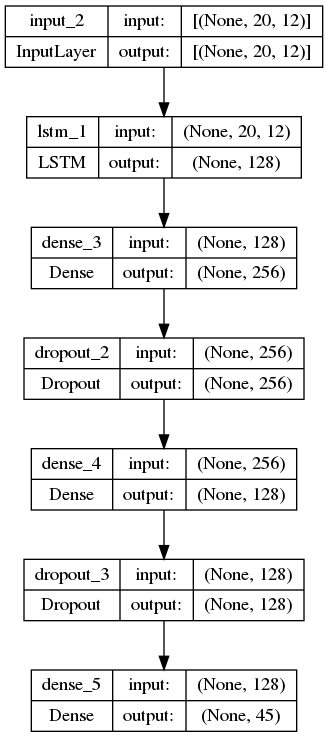

In [29]:
# Adapted from: https://keras.io/examples/rl/deep_q_network_breakout/
# model
regularisation = 0.01
dropout = 0.2
# def create_q_model():
    
#     history_inputs = layers.Input(shape=(10, 12, 3))
#     encoded_motion_inputs = layers.Input(shape=(12, 3))

#     history_cnn = layers.Conv2D(3, 3, strides=1, padding='same', activation="relu")(history_inputs)
#     history_cnn = layers.BatchNormalization(axis = 3)(history_inputs)
#     history_cnn = layers.Flatten()(history_cnn)
#     history_fcn = layers.Dense(32, activation='relu', activity_regularizer=tf.keras.regularizers.l2(regularisation))(history_cnn)

#     # Convolutions on the frames on the screen
#     encoded_cnn = layers.Conv2D(3, 3, strides=1, padding='same', activation="relu")(encoded_motion_inputs)
#     encoded_cnn = layers.Conv2D(3, 3, strides=1, padding='same', activation="relu")(encoded_cnn)
#     encoded_cnn = layers.BatchNormalization(axis = 3)(encoded_cnn)
#     encoded_cnn = layers.Flatten()(encoded_cnn)
#     encoded_fcn = layers.Dense(64, activation='relu', activity_regularizer=tf.keras.regularizers.l2(regularisation))(encoded_cnn)

#     combined_fcn = layers.Concatenate()([encoded_fcn, history_fcn])
#     combined_fcn = layers.Dropout(dropout)(combined_fcn)
#     combined_fcn = layers.Dense(512, activity_regularizer=tf.keras.regularizers.l2(regularisation), activation="relu")(combined_fcn)
#     gesture = layers.Dense(len(ENCODED_GESTURES), activation="softmax")(combined_fcn)

    # return keras.Model(inputs=(history_inputs, encoded_motion_inputs), outputs=gesture, name='GestureClassifier')
input_shape = (20, 12) # might need to drop the 3, and convert one-hot to value, e.g. 0, 1, 2...

encoded_motion_inputs = layers.Input(shape=input_shape)

lstm = layers.LSTM(128, input_shape=input_shape)(encoded_motion_inputs)

fcn = layers.Dense(256, activation='relu', activity_regularizer=tf.keras.regularizers.l2(regularisation))(lstm)
fcn = layers.Dropout(dropout)(fcn)
fcn = layers.Dense(128, activity_regularizer=tf.keras.regularizers.l2(regularisation), activation="relu")(fcn)
fcn = layers.Dropout(dropout)(fcn)
gesture = layers.Dense(len(ENCODED_GESTURES), activation="softmax")(fcn)

gesture_model = keras.Model(inputs=encoded_motion_inputs, outputs=gesture, name='GestureClassifier')

gesture_model.summary()
plot_model(gesture_model, show_shapes=True)

In [77]:
train_ds = MotionGenerator(train_data_frame, batch_size=32)
val_ds = MotionGenerator(val_data_frame, batch_size=32)
# print(train_ds.__getitem__(0)[1][0])

model_path = Path('/mnt/e/Uni/CM50175/Study/data/training_data/RNN/')
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, # learning rate determined by hyper-param-tuning
    decay_steps=(train_ds.__len__() // 2), # decay every 2 epochs
    decay_rate=0.9)
tf.debugging.set_log_device_placement(False)
# compile model
gesture_model_compiled = gesture_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics='accuracy')

gesture_model_epoch_count = 20
gesture_model_train_steps_per_epoch = train_ds.__len__()
gesture_model_val_steps_per_epoch = val_ds.__len__()

print("training steps per epoch: {}\nvalidation steps per epoch: {}".format(gesture_model_train_steps_per_epoch, gesture_model_val_steps_per_epoch))
checkpoint_path = model_path / 'checkpoints'
checkpoint_path.mkdir(exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(checkpoint_path),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5,
    mode='min', restore_best_weights=True
)

print("Fitting Transfer Learning Model (using MobileNetV2)")
gesture_model_history = gesture_model.fit(
    x = train_ds,
    validation_data=val_ds,
    epochs=gesture_model_epoch_count,
    steps_per_epoch=gesture_model_train_steps_per_epoch,
    validation_steps=gesture_model_val_steps_per_epoch,
    callbacks=[early_stop_cb, model_checkpoint_callback]
)

gesture_model.save(str(model_path / "GESTURE_MODEL.h5"))

283560
71390
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
training steps per epoch: 8861
validation steps per epoch: 2230
Fitting Transfer Learning Model (using MobileNetV2)
Epoch 1/20
4193/8861 [=============>................] - ETA: 2:01 - loss: nan - accuracy: 0.8713

KeyboardInterrupt: 

In [ ]:
# test_data_frame = get_data_frames(DATA_PATH, test_paths)

In [ ]:



# Adapted from: https://keras.io/examples/rl/deep_q_network_breakout/
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 5000#0
# Number of frames for exploration
epsilon_greedy_frames = 10000#00.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 200#0
# Using huber loss for stability
loss_function = keras.losses.Huber()
batch_size = 4

env = MotionEnv(train_data_frame)
max_steps_per_episode = len(env) // 8

# Use to make predictions
acting_model = create_q_model()
# model to predict future rewards.
model_target = create_q_model()

num_actions = len(ENCODED_GESTURES)

def get_reward(guess, actual):
    diff = np.subtract(actual, guess) # actual is one-hot encoded, 
    np.sum(diff[diff<0]) * 10 # generate loss based on probability of wrong prediction

while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0
    last_10_input = np.zeros((10, 12, 3))
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(ENCODED_GESTURES[num_actions])
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            history_tensor = tf.convert_to_tensor(last_10_input)
            history_tensor = tf.expand_dims(history_tensor, 0)
            action_probs = acting_model((history_tensor, state_tensor), training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, actual, done = env.step(action)
        reward = get_reward(state_next, actual)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = acting_model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, acting_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, acting_model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(acting_model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
    episode_count += 1

    if running_reward > -10:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break